In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def f(x):
    return 3*x**2 - 4*x + 5

Text(0, 0.5, 'y')

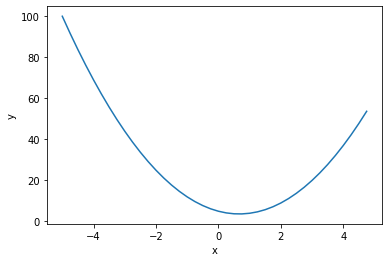

In [5]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)
plt.xlabel(xlabel='x')
plt.ylabel(ylabel='y')

In [6]:
# Let's try to get the derivative numerically (at x = 3)
h = 0.01
x = 3
(f(x + h) - f(x)) / h
for i in range(20):
    h = h * 0.1
    print((f(x + h) - f(x)) / h)
# At some point, the answer is incorrect, because of floating point arithmetic 
# and the memory for the representation of these numbers is finite.

14.00300000000243
14.000300000063248
14.00003000000538
14.000003002223592
14.000000305713908
14.000000092551085
14.000001158365187
14.000001158365187
14.000178794049125
14.001244608152765
13.997691894473965
14.210854715201993
10.658141036401494
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [7]:
# at x = 2/3
h = 0.0000001
x = 2/3
(f(x + h) - f(x)) / h
# the derivative approaches 0, so at x = 2/3 there is no response by the function to a change in x.

2.9753977059954195e-07

In [8]:
# defining the skeleton of the autograd engine
class Value:
    def __init__(self, data) -> None:
        self.data = data
    
    def __repr__(self) -> str:
        return f"Value(data={self.data})"

a = Value(2.0)
b = Value(-3.0)
# a, b are Value objects, we need to define addition for these Value objects.
a + b

TypeError: unsupported operand type(s) for +: 'Value' and 'Value'

In [ ]:
# defining the skeleton of the autograd engine
class Value:
    def __init__(self, data) -> None:
        self.data = data
    
    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        return Value(a.data + other.data)

# Now addition should work.
a = Value(2.0)
b = Value(-3.0)
a + b

Value(data=-1.0)

Now, let's add some more functionality to cover the basic arithmetical operations.

In [ ]:
# defining the skeleton of the autograd engine
class Value:
    def __init__(self, data) -> None:
        self.data = data
    
    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        return Value(self.data + other.data)
    
    def __mul__(self, other):
        return Value(self.data * other.data)

# Now addition should work.
a = Value(2.0)
b = Value(-3.0)
a + b
a * b


Value(data=-6.0)

Now, we need to create the connected tissue that allows us to know what values were used to create other values.

In [ ]:
# defining the skeleton of the autograd engine
class Value:
    def __init__(self, data, children=()) -> None:
        self.data = data
        self._prev = set(children)
    
    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        return Value(self.data + other.data, children=(self, other))
    
    def __mul__(self, other):
        return Value(self.data * other.data, children=(self, other))

# Now addition should work.
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
d = a*b + c
print(d, "children = ", d._prev)

Value(data=4.0) children =  {Value(data=-6.0), Value(data=10.0)}


We still don't have a way of tracking what operation was used to create a Value object, so 
let's do that. 

In [32]:
# defining the skeleton of the autograd engine
class Value:
    def __init__(self, data, children=(), op="", label='') -> None:
        self.data = data
        self._prev = set(children)
        self._op = op
        self.label = label
    
    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        return Value(self.data + other.data, children=(self, other), op='+')
    
    def __mul__(self, other):
        return Value(self.data * other.data, children=(self, other), op='*')

# Now addition should work.
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label = 'c')
d = a*b; d.label = 'd'
e = d + c; e.label = 'e'
f = Value(-2.0, label='f')
L = e*f; L.label = 'L'
print(d, "chilren =", d._prev, "_op =", d._op)

Value(data=-6.0) chilren = {Value(data=-3.0), Value(data=2.0)} _op = *


Now, let's create a way to visualize the graph of interconnected Value objects and their relationships
with respect to each other.

In [26]:
from graphviz import Digraph

def trace(root):
    # keep track of the nodes and edges to form a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

trace(d)

({Value(data=-3.0), Value(data=-6.0), Value(data=2.0)},
 {(Value(data=-3.0), Value(data=-6.0)), (Value(data=2.0), Value(data=-6.0))})

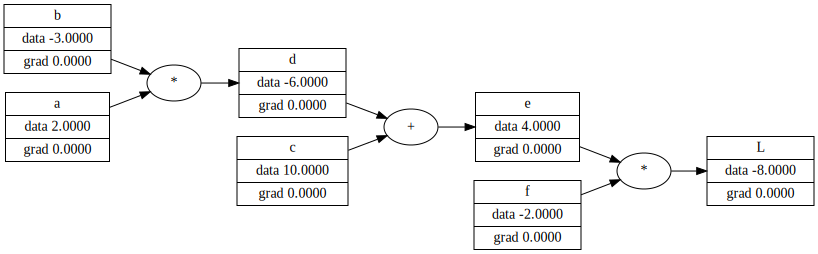

In [37]:
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir' : 'LR'}) # graph will be layed out from left to right

    nodes, edges = trace(root)
    for node in nodes:
        uid = str(id(node)) # retrieves unique id of each object
        dot.node(name = uid, label = f"{node.label} | data {node.data:.4f} | grad {node.grad:.4f}", shape='record')
        if node._op:
            # if the value is a result of an operation, create a node for the operation
            dot.node(name = uid + node._op, label=node._op)
            # connect the op node to the resulting value
            dot.edge(uid + node._op, uid)
    
    for node1, node2 in edges:
        # connect node1 to the op node of op2
        dot.edge(str(id(node1)), str(id(node2)) + node2._op)

    return dot
draw_dot(L)

Now, we still don't have a way of tracking the gradient. So, we introduce a new variable called `grad` in the Value object to keep the derivative with respect
to its child nodes.

In [36]:
# defining the skeleton of the autograd engine
class Value:
    def __init__(self, data, children=(), op="", label='') -> None:
        self.data = data
        self.grad = 0
        self._prev = set(children)
        self._op = op
        self.label = label
    
    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        return Value(self.data + other.data, children=(self, other), op='+')
    
    def __mul__(self, other):
        return Value(self.data * other.data, children=(self, other), op='*')

# Now addition should work.
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label = 'c')
d = a*b; d.label = 'd'
e = d + c; e.label = 'e'
f = Value(-2.0, label='f')
L = e*f; L.label = 'L'
print(d, "chilren =", d._prev, "_op =", d._op)

Value(data=-6.0) chilren = {Value(data=-3.0), Value(data=2.0)} _op = *


We can first try to do backpropogation manually and see how each of the inputs affect the final output.

The key here is to abide by the chain rule where the rate of change of a variable $z$ with respect to $x$, through
an intermediate variable $y$ is:

$ \frac{dz}{dx} = \frac{dz}{dy}\cdot\frac{dy}{dz}$

In [52]:
# dL/dL = 1
L.grad = 1
# dL/df = e
f.grad = 4.0
#dL/de = f
e.grad = -2.0
# dL/dd = dL/de * de/dd (Chain Rule is important here)
d.grad = -2.0 * 1.0
# dL/dc = dL/de * de/dc
c.grad = -2.0 * 1.0
# dL/db = dL/dd * dd/db
b.grad = -2.0 * 2.0
# dL/da = dL/dd * dd/da
a.grad = -2.0 * -3.0

Now, we can plot our graph and see how each variable affects the final output.

Take notice of the addition operation/node; it simply routes the derivative backwards, since it's local gradient is 1.

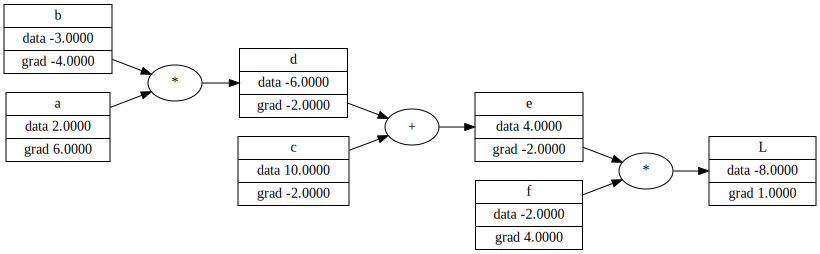

In [53]:
draw_dot(L)

Now, manually backpropogating is a bit cumbersome. 

So, we can implement a function to do these derivative calculations and do the backpropogation for us, for each operation we perform.

This function is the `_backward` function, this function will be called when we are going backwards through the graph and help us basically 
apply the chain rule.

For each operation, the `_backward` function will leave a "fingerprint" of the operation in the resulting output.

We can then call this "fingerprint" function on the output of the operation to see the gradients of the inputs with respect to the output.

In [81]:
# defining the skeleton of the autograd engine
class Value:
    def __init__(self, data, children=(), op="", label='') -> None:
        self.data = data
        self.grad = 0
        self._backward = lambda:None
        self._prev = set(children)
        self._op = op
        self.label = label
    
    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, children=(self, other), op='+')

        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward         # we are not calling _backward, they return None, we are storing the function itself.

        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, children=(self, other), op='*')

        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward =_backward

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, children=(self, ), op='tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward
        
        return out


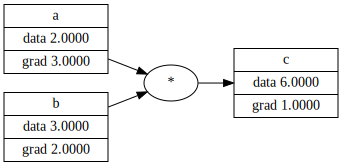

In [86]:
a = Value(2.0, label='a')
b = Value(3.0, label='b')
c = a*b; c.label = 'c'
c.grad = 1.0
c._backward()
draw_dot(c)

With this help, we can try to backpropogate on a slightly different set of operations: the mathematical model of the Neuron.

In [68]:
# simple neuron with two inputs, and thus 2 weights, and a bias
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias value of the neuron
b = Value(6.881373, label='b')
#x1*w1 + x2*w2 + b = n
x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
# output = tanh(n)
o = n.tanh(); o.label ='o'

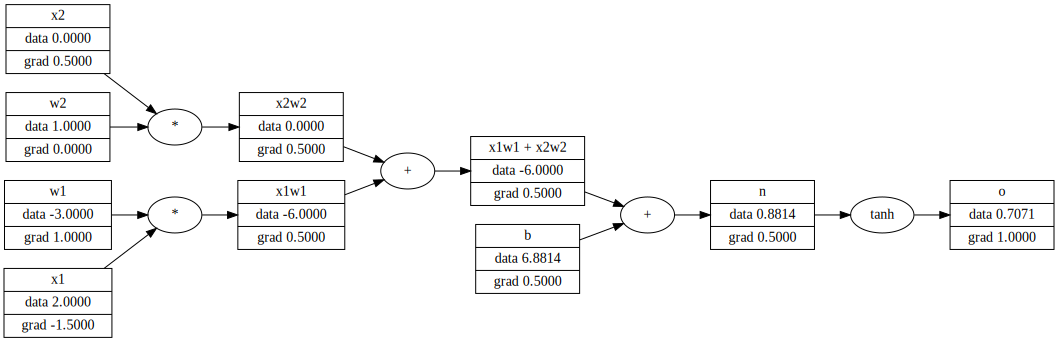

In [80]:
o.grad = 1.0 # since the gradient of o w.r.t o is just 1.
draw_dot(o)

In [76]:
o._backward()
n._backward()

In [77]:
b._backward() # won't return anything since it is not the result of an operation
x1w1x2w2._backward()

In [79]:
x2w2._backward()
x1w1._backward()

Even still, calling _backward() manually is a bit cumbersome as well, although less cumbersome than the manual differentiation.

We can instead, organize the nodes in a particular order, so that the leaf nodes ( inputs that aren't the result of an operation ) are last and the root node is first. 

Then, recursively apply the _backward function from the root node to the leaf nodes. 

We can do this by doing a topological sort, then reversing the result. 
From my understanding, a topological sort makes sure that every node is ordered such that for every edge between nodes A and B, A comes before B.

In [ ]:
# topological sort
def topological_sort():

In [ ]:
# defining the skeleton of the autograd engine
class Value:
    def __init__(self, data, children=(), op="", label='') -> None:
        self.data = data
        self.grad = 0
        self._backward = lambda:None
        self._prev = set(children)
        self._op = op
        self.label = label
    
    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, children=(self, other), op='+')

        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward         # we are not calling _backward, they return None, we are storing the function itself.

        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, children=(self, other), op='*')

        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward =_backward

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, children=(self, ), op='tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
